20240726 접촉 Stiffness 시뮬레이션 비교

* 필요 패키지 사용

In [ ]:
import numpy as np
import mujoco
import mujoco.viewer
import mediapy as media

import time
import serpenoid
import serpenoid_gamma

* 시뮬레이션 정의 파일 불러오기

In [ ]:
debris = mujoco.MjModel.from_xml_path("./contact_testing.xml")
data = mujoco.MjData(debris)
renderer = mujoco.Renderer(debris, 720, 1280)


* 시뮬레이션 진행 (영상 렌더링)

In [30]:
t_step = debris.opt.timestep
stepspersecond = int(1/t_step)

frames = []
contact_force = []

mujoco.mj_forward(debris, data)

for i in range(2*stepspersecond):
    mujoco.mj_step(debris, data)
    renderer.update_scene(data)
    pixel = renderer.render()

    frames.append(pixel)
    contact_force.append(data.sensordata[1])

# media.show_video(frames, fps=stepspersecond)

* 접촉힘 플롯

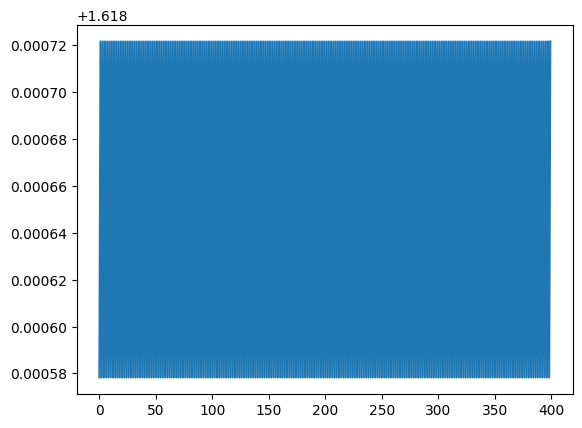

In [36]:
import matplotlib.pyplot as plt


plt.plot(contact_force[0:500])